# Competitive Evaluation

## Setup

In [47]:
%matplotlib notebook

import itertools
import logging
from functools import partial
from collections import defaultdict

import gensim
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
import numpy as np
import pandas as pnd
import os
from sklearn.cluster import *
from sklearn.preprocessing import normalize
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics
from multiprocessing import Pool
from knub.thesis.util import *

pnd.set_option("display.max_colwidth", 200)

## Topic Coherence

### Setup

* **Number of topics:** $K = 50$ for both *20news* and *nips*

**Approach**:
1. TM Corpus: lowercasing, tokenization, stopwords removal
2. WE Corpus: Wikipedia corpus trained with 50, 100, 200 dimensions
3. Restrict TM corpus to words which occur in WE model
4. Train different competitors
5. Evaluate TC using Palmetto tool from *Exploring the Space of Topic Coherence Measures* using the $C_V$ topic coherence measure


In [48]:
def load_topic_coherence(f):
    return pnd.read_csv("/home/stefan.bunk/master-thesis/results/topic-coherence/" + f, sep="\t", header=None)
    

def plot_iteration_for(df_param, params, r=0.9):
    matplotlib.style.use('classic')
    plt.figure()
    colors = iter(["green", "red", "blue", "yellow"] + plt_colors.cnames.keys())
    for model, df_group in df_param.groupby(params):
        plt.plot(df_group["iteration"], df_group["TC"] * 100, linestyle="None", color='white',
                 label=model, marker='o', markerfacecolor=next(colors), markersize=12)

    plt.xlabel("Iteration")
    plt.ylabel("Topic Coherence")
    
    min_TC = df_param["TC"].min() * 100
    max_TC = df_param["TC"].max() * 100
    diff_TC = max_TC - min_TC
    lower_TC = min_TC - r * diff_TC
    upper_TC = max_TC + r * diff_TC
    plt.ylim((lower_TC, upper_TC))
    
    plt.xlim((df_param["iteration"].min() - 20, df_param["iteration"].max() + 20))

    plt.legend(loc="best")

### Base LDA

In [66]:
df_tc_lda = load_topic_coherence("lda.txt")
df_tc_lda.columns = ["alpha", "beta", "TC", "TC_std"]
df_tc_lda = df_tc_lda.sort_values("TC", ascending=False)
df_tc_lda

,alpha,beta,TC,TC_std
15,0.010,0.020,0.434,0.065
7,0.005,0.005,0.432,0.076
27,0.050,0.020,0.432,0.065
11,0.005,0.100,0.430,0.076
19,0.020,0.005,0.429,0.068
2,0.002,0.010,0.428,0.073
25,0.050,0.005,0.427,0.074
29,0.050,0.100,0.426,0.074
0,0.002,0.002,0.424,0.068
6,0.005,0.002,0.424,0.077


<IPython.core.display.Javascript object>


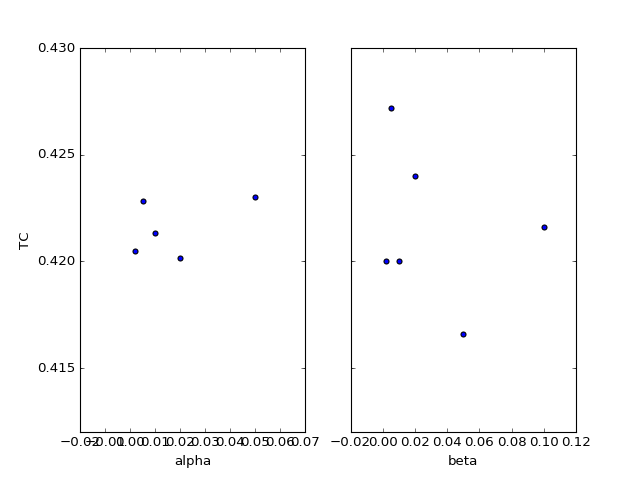

In [69]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

df_tc_lda.groupby("alpha").mean().reset_index().plot(x="alpha", y="TC", kind="scatter", ax=ax1)
df_tc_lda.groupby("beta").mean().reset_index().plot(x="beta", y="TC", kind="scatter", ax=ax2)

In [56]:
df_tc_lda["TC"].mean()

0.4215666666666667

In [148]:
df_tc_lda_nips = load_topic_coherence("lda_nips.txt")
df_tc_lda_nips.columns = ["alpha", "beta", "TC", "TC_std"]
#df_tc_lda_nips = df_tc_lda_nips.sort_values("TC", ascending=False)
df_tc_lda_nips

,alpha,beta,TC,TC_std
0,0.002,0.005,0.409,0.061
1,0.002,0.010,0.391,0.056
2,0.002,0.020,0.403,0.052
3,0.002,0.050,0.407,0.057
4,0.002,0.100,0.406,0.056
5,0.005,0.002,0.401,0.057
6,0.005,0.005,0.412,0.058
7,0.005,0.010,0.398,0.062
8,0.005,0.020,0.401,0.065
9,0.005,0.050,0.406,0.063


In [143]:
df_tc_lda_nips["TC"].mean()

0.401448275862069

**TODO**: Add new results from alpha-beta search
Also do some for nips

### LFLDA

LFLDA does not sample only from the multinomial topic-word distribution as LDA, but also in the embedding space by defining a word distribution for a given topic based on the similarity of words with the topic vector.
From which distribution to sample from is governed by the $\lambda$ parameter.

* $\alpha$, $\beta$: same as standard LDA
* $\lambda$: mixing factor between multinomial LDA and word embedding probability distribution. $\lambda = 1.0$ was reported to achieve highest topic coherence

In [144]:
df_tc_lflda = load_topic_coherence("lflda.txt")
df_tc_lflda.columns = ["embedding-dimension", "lambda", "alpha", "beta", "iteration", "TC", "TC_std"]
#df_tc_lflda = df_tc_lflda[df_tc_lflda["lambda"] == 0.6]
df_tc_lflda = df_tc_lflda[(df_tc_lflda["iteration"] - 1) % 10 == 2]
df_tc_lflda.head()

,embedding-dimension,lambda,alpha,beta,iteration,TC,TC_std
2,200,0.6,0.02,0.02,3,0.445,0.097
3,200,1.0,0.02,0.02,3,0.464,0.095
12,200,0.6,0.02,0.02,13,0.445,0.092
13,200,1.0,0.02,0.02,13,0.450,0.095
22,200,0.6,0.02,0.02,23,0.439,0.083


<IPython.core.display.Javascript object>


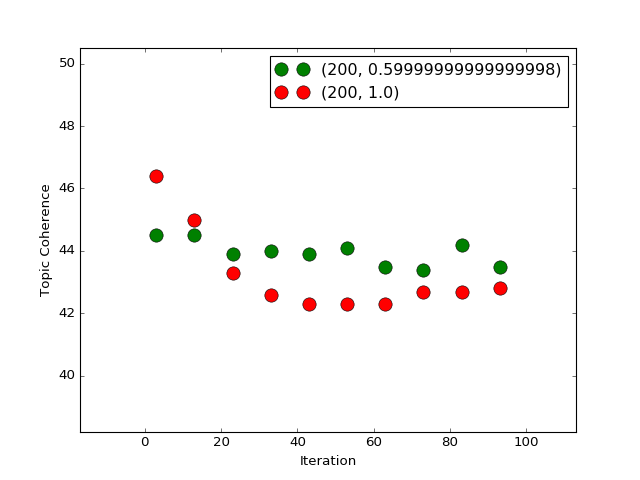

In [145]:
plot_iteration_for(df_tc_lflda, ["embedding-dimension", "lambda"], r=1)

In [149]:
df_tc_lflda2 = load_topic_coherence("lflda2.txt")
df_tc_lflda2.columns = ["embedding-dimension", "lambda", "alpha", "beta", "iteration", "TC", "TC_std
df_tc_lflda2.head()

,embedding-dimension,lambda,alpha,beta,iteration,TC,TC_std
0,200,0.6,1.746947,0.01607,0,0.420,0.075
1,200,0.6,1.746947,0.01607,1,0.429,0.075
2,200,0.6,1.746947,0.01607,2,0.440,0.093
3,200,0.6,1.746947,0.01607,3,0.442,0.095
4,200,0.6,1.746947,0.01607,4,0.443,0.091


<IPython.core.display.Javascript object>


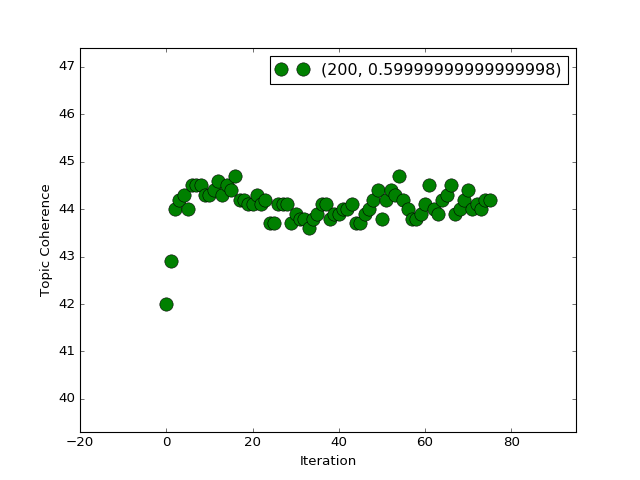

In [150]:
plot_iteration_for(df_tc_lflda2, ["embedding-dimension", "lambda"], r=1)

**Results**:
LFTM achieves improvements of $~ 1.8$ in TC.
Training time is very slow (see below).

**TODO**:
* In theory, LFTM should benefit from higher nr. of dimensions and should achieve lower results with less dimensions.
* NIPS!

### TopicVec

TopicVec replaces the multinomial topic-word distribution from LDA and replaces with an WE-inspired word distribution based on the immediate context of a word. Topics are points in the embedding space.

**Parameters**:

* number of topic dimensions
* $\alpha$: same as LDA

In [338]:
df_tc_topicvec = load_topic_coherence("topicvec.txt")
df_tc_topicvec.columns = ["corpus", "embedding-dimension", "iteration", "TC", "TC_std"]
df_tc_topicvec = df_tc_topicvec.sort_values(["corpus", "embedding-dimension", "iteration"])
df_tc_topicvec.head()

,corpus,embedding-dimension,iteration,TC,TC_std
33,orig,50,100,0.426,0.085
35,orig,50,500,0.468,0.069
34,orig,100,100,0.414,0.070
36,orig,200,500,0.485,0.082
1,our,50,1,0.312,0.019


<IPython.core.display.Javascript object>


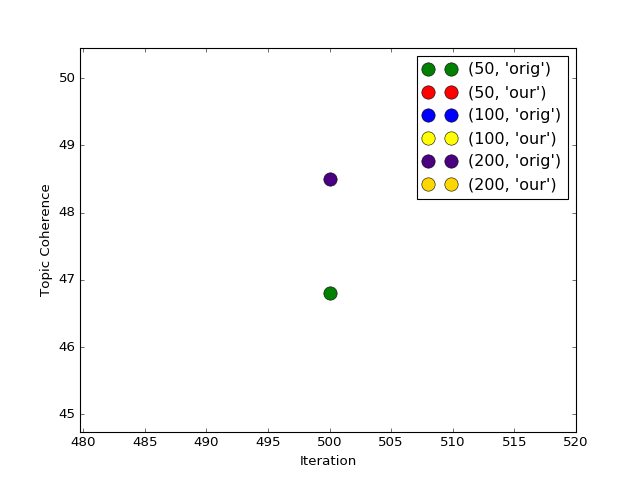

In [339]:
plot_iteration_for(df_tc_topicvec, ["embedding-dimension", "corpus"])

**Results**:
TopicVec achieves the highest topic coherence with 46.8.
Higher dimensions converge slower, but seem to end with higher TC.

**TODO**:
* TopicVec achieves higher results with the original data set, which does not lowercase, does not remove stop words.
* Need to explore the space between 100-500 iterations

In [15]:
df_tc_topicvec_topics = pnd.read_csv("/home/stefan.bunk/topicvec/results/corpus-orig.dim-50.iterations-500/topics", sep=" ", header=None)
df_tc_topicvec_topics.columns = ["topic-id", "probability"] + list(range(1, 11))
df_tc_topicvec_topics

,topic-id,probability,1,2,3,4,5,6,7,8,9,10
0,25,0.068338,god,faith,moral,morality,truth,christians,religion,atheists,belief,bible
1,23,0.056404,encryption,file,key,available,use,information,files,software,server,data
2,38,0.049740,output,scsi,file,jpeg,printf,image,window,null,stream,memory
3,49,0.048265,armenians,armenian,turkish,armenia,israel,soldiers,azerbaijan,turks,villages,lebanese
4,48,0.047695,card,drive,disk,drives,sale,floppy,windows,video,controller,price
5,46,0.046646,writes,says,mamma,jesus,know,went,told,apartment,come,father
6,4,0.046221,engine,car,windows,speed,brake,use,wiring,drive,cars,like
7,30,0.040092,team,hockey,players,season,game,nhl,league,teams,games,play
8,42,0.039293,pts,period,game,pit,puck,flyers,detroit,scorer,boston,philadelphia
9,47,0.038447,government,law,court,amendment,rights,state,constitution,right,laws,militia


**With 20news.dim-50 embeddings**

<IPython.core.display.Javascript object>


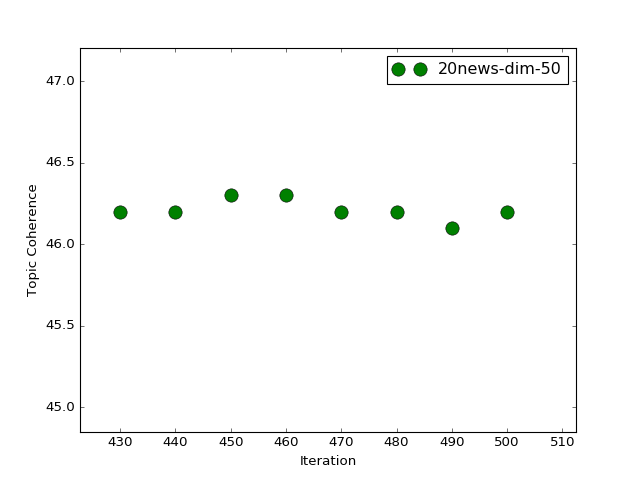

In [289]:
df_tc_topicvec_20news_dim50 = load_topic_coherence("topicvec.embedding-20news-dim-50.txt")
df_tc_topicvec_20news_dim50.columns = ["embedding", "iteration", "TC", "TC_std"]
df_tc_topicvec_20news_dim50 = df_tc_topicvec_20news_dim50.sort_values(["embedding", "iteration"])
plot_iteration_for(df_tc_topicvec_20news_dim50, ["embedding"])

### Gaussian LDA

Learning works better with **lower number of dimensions** (50 instead of 200).
Results are better, but still not good

> Yes, I have a feeling, I ran the experiments on 50 dimensional vectors.
> I am a little sad that it does not work for higher dimensional embeddings, but clearly there is something interesting going on which might give some insights about the structure of the space. Can you point me to the topics for D = {50, 200}.


Topics are better, but still not good. Previously, the topics were **almost uniform**.

Now, actual topics emerge but there are still a lot of noise topics. **Pre-initializing the topic vectors** to the **mean** of standard LDA's topics did not help

**Parameters:**
* $\alpha$: as in standard LDA
* number of dimensions

In [18]:
pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/old/dim-50.alpha-0-02.output/090.topics", sep=" ", header=None)

,0,1,2,3,4,5,6,7,8,9
0,squarewave,quickdraw,reradiated,power-assist,push-pin,guard-rails,degauss,lightmeter,air-filter,encryptor
1,strong-hold,s.q,vatican,salyuts,a.s.s,offroading,stillwater,jcfs,rts,fusebox
2,s.q,f.a.q,o.h.o,wetbike,lernu,strong-hold,wob,a.i.d.s,c.r,xtian
3,three,two,good,many,new,first,four,second,several,last
4,people,government,world,group,israel,jews,national,germany,turkish,israeli
5,state,s.q,strong-hold,wiley,u.u,bill,stang,nelly,cayman,apple
6,buy,purchase,sell,buying,bought,purchasing,sale,sold,out-of-staters,pay
7,pre-judged,obviously,bullshitting,clearly,o.h.o,acknowledged,brought,effectively,s.q,even
8,f.a.q,wayner,a.s.s,s.q,hoffman,wetbike,slc,x-news,appelquist,xev
9,team,game,white,games,play,black,players,red,blue,win


In [122]:
df_tc_gaussian = load_topic_coherence("gaussian_lda.txt")
df_tc_gaussian.columns = ["iteration", "initialization-method", "embedding-dimension", "alpha", "TC", "TC_std"]
df_tc_gaussian = df_tc_gaussian.sort_values(["embedding-dimension", "initialization-method", "alpha", "iteration"])
df_tc_gaussian.head()

,iteration,initialization-method,embedding-dimension,alpha,TC,TC_std
43,0,mean,50,0.02,0.260,0.016
44,10,mean,50,0.02,0.347,0.084
45,20,mean,50,0.02,0.356,0.091
46,30,mean,50,0.02,0.360,0.090
47,40,mean,50,0.02,0.369,0.090


<IPython.core.display.Javascript object>


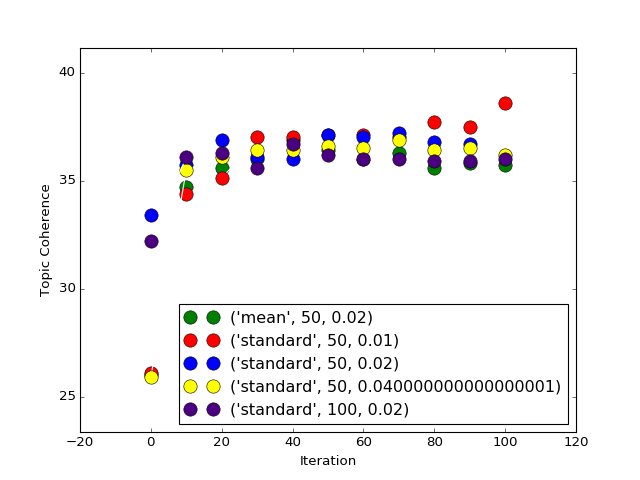

In [123]:
plot_iteration_for(df_tc_gaussian, ["initialization-method", "embedding-dimension", "alpha"], r=0.2)

**Iterations against likelihood**

<IPython.core.display.Javascript object>


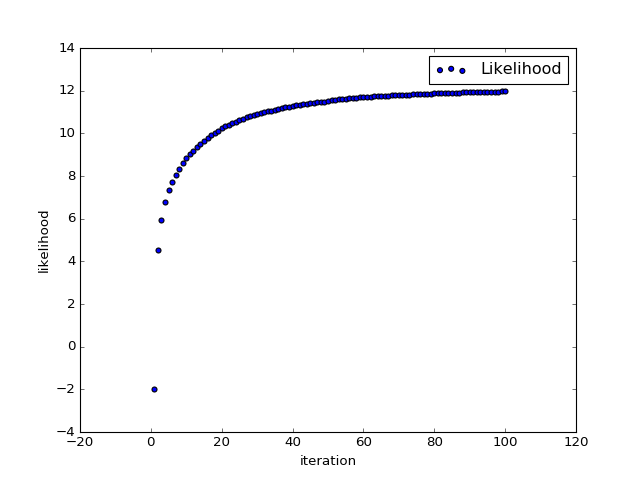

In [22]:
df_tc_gaussian_iterations = pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/old/initialization-mean.dim-50.alpha-0-02.output/iterations.txt", sep="\t")
df_tc_gaussian_iterations.plot("iteration", "likelihood", kind="scatter", label="Likelihood")

**Time for each iteration**

<IPython.core.display.Javascript object>


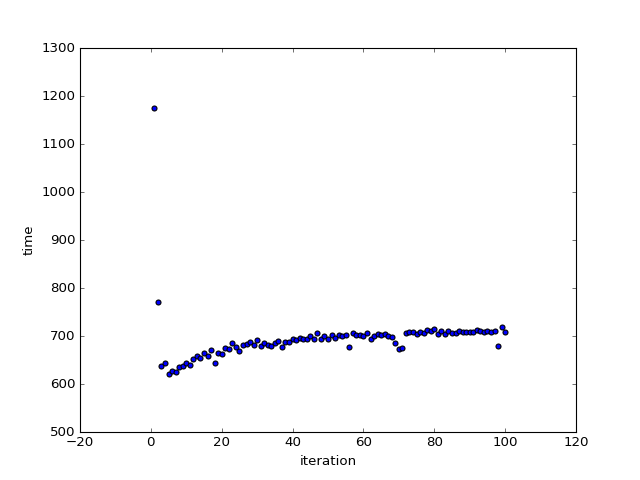

In [23]:
df_tc_gaussian_iterations.plot("iteration", "time", kind="scatter")

**Results:** Gaussian LDA achieves the lowest TC of all systems. Also, the model cannot handle higher dimensions.

**TODO:**
* Answer author, no further investigation until new insights

**NIPS**

<IPython.core.display.Javascript object>


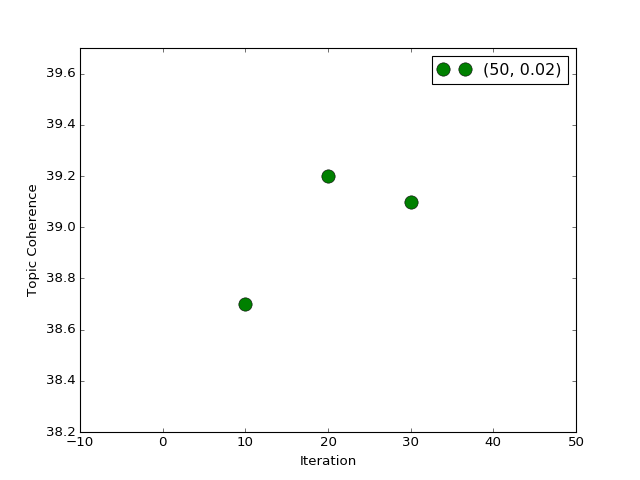

In [137]:
df_tc_gaussian_nips = load_topic_coherence("gaussian_lda_nips.txt")
df_tc_gaussian_nips.columns = ["iteration", "dataset", "embedding-dimension", "alpha", "TC", "TC_std"]
plot_iteration_for(df_tc_gaussian_nips, ["embedding-dimension", "alpha"], r=1.0)

In [138]:
pnd.read_csv("/home/stefan.bunk/Gaussian_LDA/results/data-nips.dim-50.alpha-0-02/030.topics", sep=" ", header=None)

,0,1,2,3,4,5,6,7,8,9
0,number,examples,structure,architecture,independent,references,complex,effect,changes,scheme
1,computational,components,computer,dynamic,applications,optimization,application,technology,implementation,global
2,schottky,r/c,arris,hollow,pcb,soft,rod,circular,aston,tvs
3,size,real,true,equal,amount,shape,product,sense,yields,quantity
4,connections,line,proposed,connection,connected,lines,selected,added,link,delays
5,states,location,code,motor,pairs,exact,parts,storage,configuration,sequential
6,fortran,vec,uop,thau,tamar,canu,opo,eme,puls,dax
7,term,positive,classifier,variable,negative,report,bias,weighted,normalized,york
8,figure,shown,shows,features,described,presented,found,basis,represent,presents
9,field,points,level,step,table,lower,right,phase,left,higher


### sHDP

Similar to Gaussian LDA, but models a von Mises-Fisher distribution on the hypercube instead of a Gaussian distribution in the embedding space.

**Parameters**:
* $\kappa \in (0.5, 1]$, $\tau \in [0;)$: parameters for the learning rate of SGD
* $\gamma$: stick-breaking parameter 
* $\alpha$: concentration parameter for the Dirichlet process

So far no results with 20news. **Parameter search** did not help:

> As far as I remember we couldn't get the same good performance of nips dataset with 20news (as we reported in Table 2). However, other methods were also doing poorly on the same dataset. One reason for that could be using 50-dimensional word2vec representations; we didn't try other possible pretrained word vector representations with higher dimensions (e.g. Glove). Also we didn't try larger minibatch sizes (e.g. 100) for SVI training. These modifications might have improved the results for 20news corpus.  

> We've been using the model in the medical domain and we are getting good performance; however, one observation that we had was the quality of the sHDP is dependent on the quality of pretrained word vectors that we use.

In [24]:
# kappa, tau in [(0.6, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    # alpha in [0.5, 0.9, 1.0, 1.5, 10]:
        # gamma in [0.5, 1.0, 1.5, 10]:
            # run_shdp()

<IPython.core.display.Javascript object>


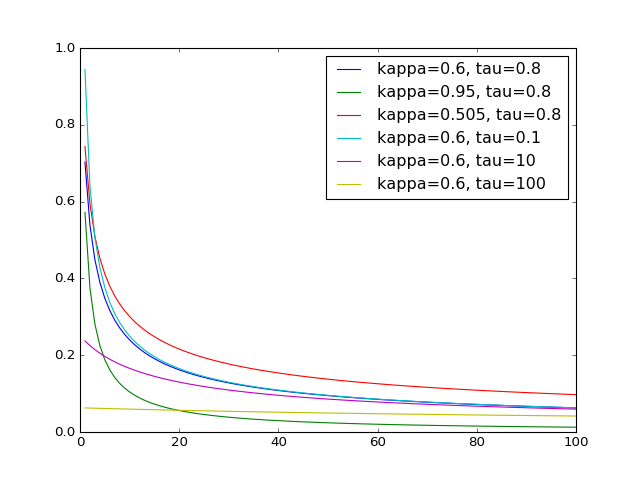

In [25]:
x = np.arange(1, 101)
plt.figure()
for kappa, tau in [(0.6, 0.8), (0.95, 0.8), (0.505, 0.8), (0.6, 0.1), (0.6, 10), (0.6, 100)]:
    y = (x + tau)**(-kappa)
    plt.plot(x, y, label="kappa=" + str(kappa) + ", tau=" + str(tau))

plt.legend()

In [152]:
df_tc_shdp_nips = load_topic_coherence("shdp_nips.txt")
df_tc_shdp_nips.columns = ["embeddings", "dimensions", "seed", "topics", "alpha", "gamma",
                           "kappa", "tau", "step-size", "TC", "TC_std"]
df_tc_shdp_nips["iteration"] = 1
df_tc_shdp_nips

,embeddings,dimensions,seed,topics,alpha,gamma,kappa,tau,step-size,TC,TC_std,iteration
0,theirs,50,1,50,1.0,2.0,0.6,0.8,10,0.375,0.084,1
1,ours,50,1,50,1.0,2.0,0.6,0.8,10,0.362,0.058,1


<IPython.core.display.Javascript object>


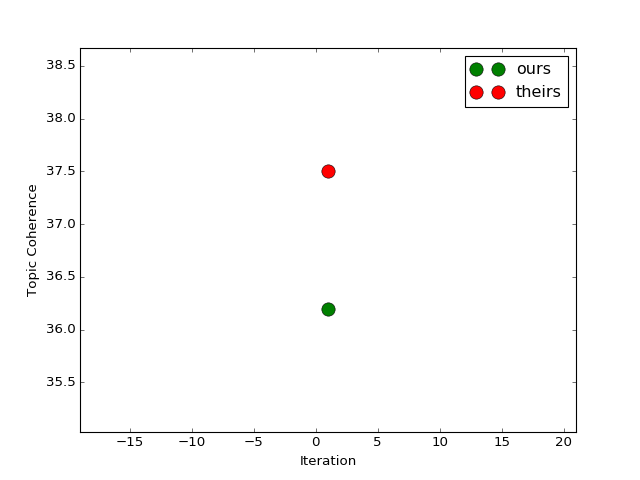

In [153]:
plot_iteration_for(df_tc_shdp_nips, ["embeddings"])

**NIPS**

In [29]:
df_tc_shdp_nips_topics = pnd.read_csv("/home/stefan.bunk/sHDP/results/20news/embeddings-ours.dim-50.seed-1.topics-50.alpha-1-0.gamma-2-0.kappa-0-6.tau-0-8.batch-10/prob-based.topics", header=None, sep=" ")
df_tc_shdp_nips_topics

,0,1,2,3,4,5,6,7,8,9
0,computation,solution,approximation,stochastic,entropy,errors,generalize,data,calculate,nonlinear
1,ten,training,list,probability,times,number,features,kaufmann,function,length
2,code,updates,applications,derived,parameter,mapping,inputs,output,data,methods
3,networks,centers,measure,shown,related,points,gaussian,weight,proceedings,show
4,activated,trained,unit,total,apply,layer,error,decrease,representation,operations
5,current,positions,networks,division,find,show,layer,form,effects,section
6,model,input,circuitry,neural,frequencies,left,analysis,found,press,abstract
7,partial,caused,change,resulting,lack,positive,set,increasing,stimulus,shown
8,version,presentation,information,shown,current,network,shows,space,show,research
9,consisting,report,means,local,dependent,splitting,processes,factor,information,achieve


**Results**:
Similarly to Gaussian LDA, learning a model/finding the right parameters is hard. The model also seems to have a problem with higher dimensions.

**TODO**:
* Ask author for regarding parameter settings for 20news

### WELDA-Gaussian

WELDA resamples the words in the text based on a Gaussian distribution over the topic space. The resample probability is $\lambda$.

* $\alpha$, $\beta$: standard LDA
* $\lambda$: resample probability

<IPython.core.display.Javascript object>


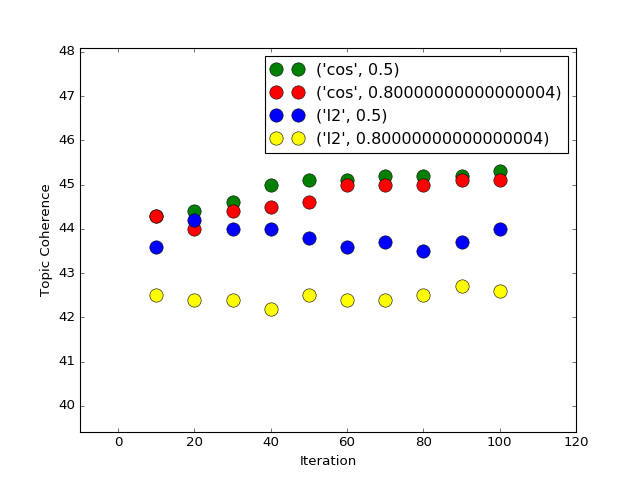

In [49]:
df_tc_welda = load_topic_coherence("gaussian_welda.txt")
df_tc_welda.columns = ["iteration", "distance-method", "lambda", "TC", "TC_std"]
df_tc_welda = df_tc_welda.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda, ["distance-method", "lambda"])

**Results**:
WELDA increases the TC compared to standard LDA by $~ 2.8$. After topicvec, it is the second best model with regards to TC.

<IPython.core.display.Javascript object>


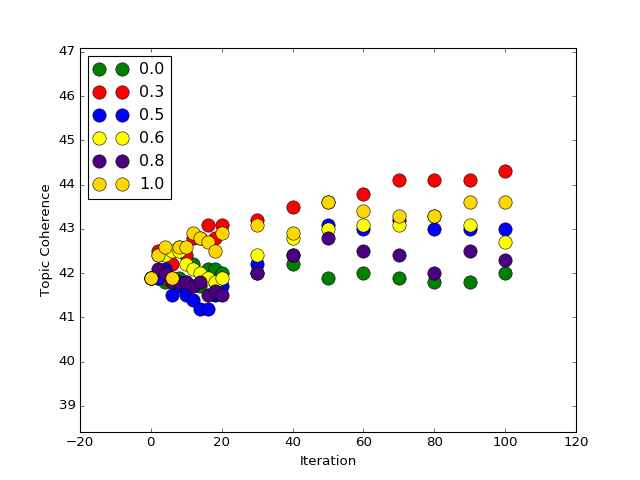

In [50]:
df_tc_welda_2 = load_topic_coherence("gaussian_welda2.txt")
df_tc_welda_2.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_2 = df_tc_welda_2.sort_values(["lambda", "iteration"])
plot_iteration_for(df_tc_welda_2, ["lambda"])

**With 20news.dim-50 embedding**

<IPython.core.display.Javascript object>


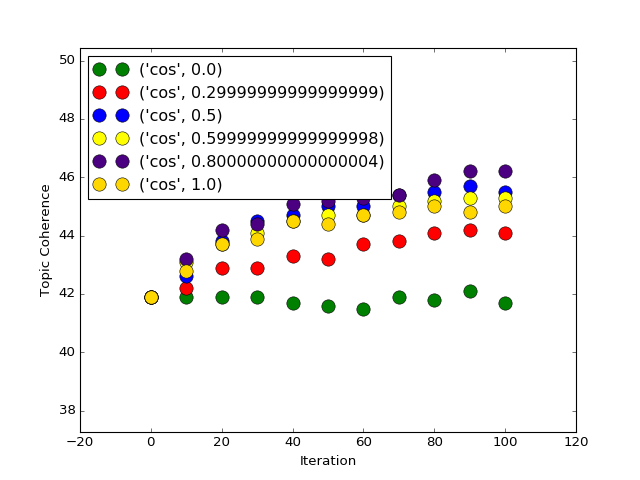

In [51]:
df_tc_welda_gaussian_20news = load_topic_coherence("gaussian_welda.embedding-20news-dim-50.txt")
df_tc_welda_gaussian_20news.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_gaussian_20news = df_tc_welda_gaussian_20news.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_gaussian_20news, ["distance-method", "lambda"])

**NIPS**

In [111]:
df_tc_nips_welda = load_topic_coherence("gaussian_welda_nips.txt")
df_tc_nips_welda.columns = ["iteration", "embedding-dimensions", "distance-method", "lambda", "TC", "TC_std"]
df_tc_nips_welda = df_tc_nips_welda[df_tc_nips_welda["iteration"] % 10 == 0]
df_tc_nips_welda.head()

,iteration,embedding-dimensions,distance-method,lambda,TC,TC_std
0,0,200,cos,0.5,0.409,0.055
5,10,200,cos,0.5,0.406,0.063
10,20,200,cos,0.5,0.412,0.065
15,30,200,cos,0.5,0.411,0.067
20,40,200,cos,0.5,0.415,0.069


In [117]:
#plot_iteration_for(df_tc_nips_welda, ["lambda"])

<IPython.core.display.Javascript object>


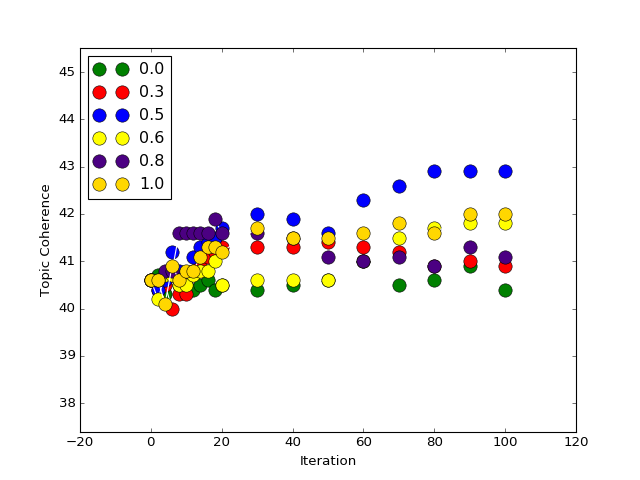

In [49]:
df_tc_nips_welda2 = load_topic_coherence("gaussian_welda_nips2.txt")
df_tc_nips_welda2.columns = ["embedding-dimensions", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_nips_welda2, ["lambda"])

**Results:** Again WELDA increases the TC by $0.4$

**New sampling method**

In [52]:
df_tc_welda3 = load_topic_coherence("gaussian_welda.sampling-corrected.txt")
df_tc_welda3.columns = ["embedding-dimensions", "distance-method", "lambda", "iteration", "TC", "TC_std"]

<IPython.core.display.Javascript object>


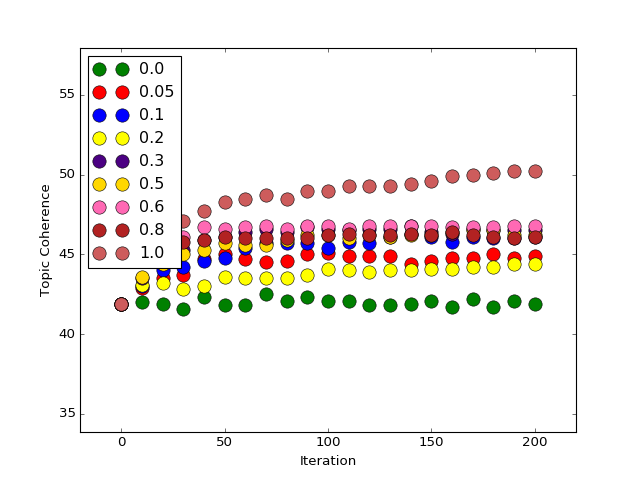

In [53]:
plot_iteration_for(df_tc_welda3[df_tc_welda3["embedding-dimensions"] == "20news-50"], ["lambda"])

<IPython.core.display.Javascript object>


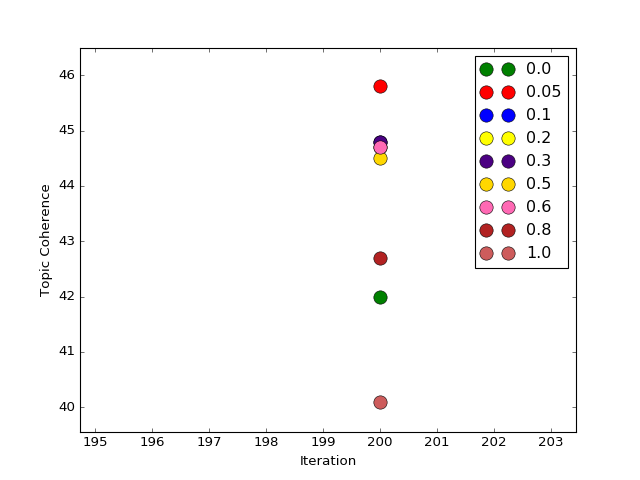

In [312]:
plot_iteration_for(df_tc_welda3[df_tc_welda3["embedding-dimensions"] == "200"], ["lambda"])

**Topics from the overfitted lambda=1.0 experiment**

In [80]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-1-0/welda.iteration-200.topics",
    sep=" ", header=None)

,0,1,2,3,4,5,6,7,8,9,10
0,0,klopfenstein,jeffery,jill,mahan,dickey,felder,novak,hui,dsh,usui
1,1,viking,anderson,douglas,d.f,hugo,space,steven,auburn,larc,suppose
2,2,tal,frederick,billy,chung,hsiung,shaw,drive,csc,scsi,zur
3,3,watson,mau,broward,warren,president,stephanopoulos,arf,jefferson,dwayne,padi
4,4,roberts,steven,wade,lam,crh,mst,perry,staudt,joes,callison
5,5,bernstein,lewis,frederick,prasad,warren,sherman,berry,montuno,steven,albert
6,6,moore,carol,simon,anderson,wrote,god,fisher,hal,jesus,suppose
7,7,dsh,kubo,godwin,carr,tal,dfo,meyers,tavares,nightly,law
8,8,peter,william,lewis,dan,apr,courtesy,nope,alexander,like,article
9,9,carrion,eaton,deepak,file,entry,output,program,mcmains,posting,int


**Topics from the best lambda=0.6 experiment**

In [54]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics",
    sep=" ", header=None)


IOError: File /data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics does not exist

**Top sampling**

<IPython.core.display.Javascript object>


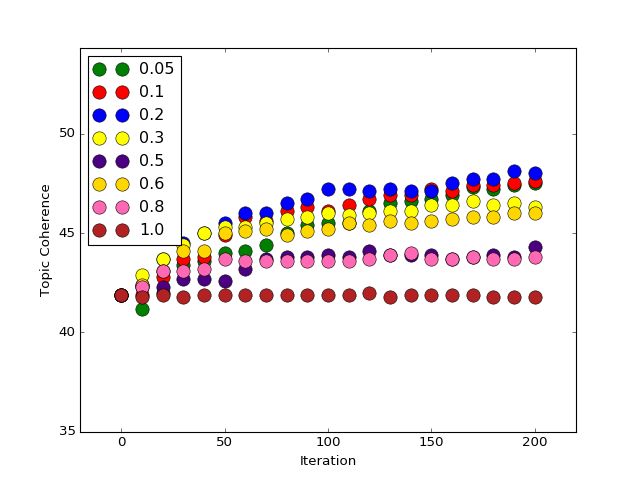

In [319]:
df_tc_welda_top = load_topic_coherence("gaussian_welda_top.txt")
df_tc_welda_top.columns = ["file", "embedding-dimensions", "sampling", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_welda_top[df_tc_welda_top["embedding-dimensions"] == "20news-50"], ["lambda"])

<IPython.core.display.Javascript object>


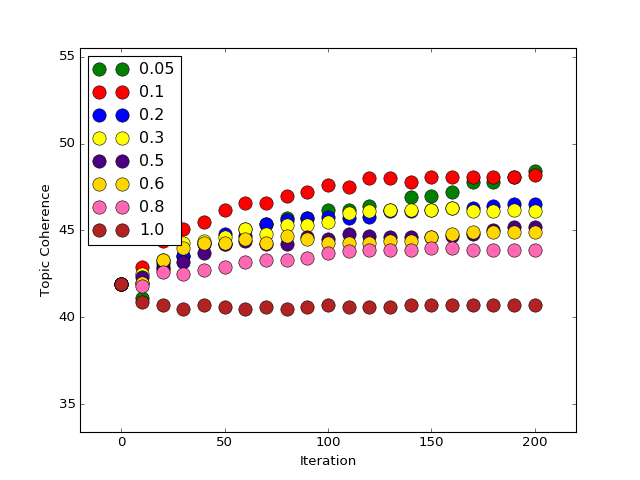

In [320]:
df_tc_welda_top = load_topic_coherence("gaussian_welda_top.txt")
df_tc_welda_top.columns = ["file", "embedding-dimensions", "sampling", "distance-method", "lambda", "iteration", "TC", "TC_std"]
plot_iteration_for(df_tc_welda_top[df_tc_welda_top["embedding-dimensions"] == "200"], ["lambda"])

In [322]:
df_tc_welda_top[df_tc_welda_top["TC"] > 0.48]

,file,embedding-dimensions,sampling,distance-method,lambda,iteration,TC,TC_std
61,model.20news.dim-50.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-2/welda.iteration-190.topics,20news-50,top,cos,0.20,190,0.481,0.084
187,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-190.topics,200,top,cos,0.05,190,0.481,0.096
188,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-200.topics,200,top,cos,0.05,200,0.484,0.095
204,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-150.topics,200,top,cos,0.10,150,0.481,0.086
205,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-160.topics,200,top,cos,0.10,160,0.481,0.087
206,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-170.topics,200,top,cos,0.10,170,0.481,0.087
207,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-180.topics,200,top,cos,0.10,180,0.481,0.088
208,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-190.topics,200,top,cos,0.10,190,0.481,0.089
209,model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-200.topics,200,top,cos,0.10,200,0.482,0.090


In [326]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-1/welda.iteration-080.topics",
    sep=" ", header=None).drop(0)

,0,1,2,3,4,5,6,7,8,9,10
1,1,space,launch,nasa,orbit,satellite,lunar,shuttle,mission,spacecraft,earth
2,2,scsi,drive,drives,disk,ide,controller,hard,setting,mb/s,bus
3,3,president,stephanopoulos,give,setting,myers,jobs,package,tax,bring,administration
4,4,car,cars,engine,oil,tires,miles,speed,mph,ford,brake
5,5,science,theory,scientific,happening,conference,larson,research,university,backgrounds,excellent
6,6,god,jesus,give,christ,bible,church,christians,faith,bring,lord
7,7,militia,amendment,file,gun,firearms,law,arms,constitution,weapon,firearm
8,8,yet,putting,still,would,though,even,one,lot,every,actually
9,9,entry,output,file,printf,int,char,entries,program,expectedly,rules
10,10,israel,israeli,jews,arab,arabs,lebanese,lebanon,israelis,gaza,palestinian


In [327]:
pnd.read_csv(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.welda.gaussian-top.distance-cos.lambda-0-05/welda.iteration-200.topics",
    sep=" ", header=None).drop(0)


,0,1,2,3,4,5,6,7,8,9,10
1,1,orbit,space,launch,satellite,lunar,spacecraft,nasa,mission,mars,propulsion
2,2,scsi,drive,ide,drives,controller,disk,mb/s,bios,bus,isa
3,3,stephanopoulos,president,recreate,give,myers,forth,vat,jobs,dole,dee
4,4,car,cars,engine,oil,tires,sho,brake,brakes,integra,miles
5,5,surprising,mediocre,larson,science,theory,mistakes,fulk,methodology,scientific,unified
6,6,jesus,god,give,christ,bible,forth,father,hoax,spirit,wanting
7,7,militia,amendment,firearm,firearms,weapon,arms,forth,constitution,right,regulated
8,8,realize,something,wrong,think,hurting,mistakes,looked,felt,would,enough
9,9,entry,output,printf,char,file,entries,int,stream,buf,contest
10,10,israel,israeli,lebanese,arab,arabs,lebanon,israelis,gaza,palestinian,palestinians


**PCA sampling analysis**

In [336]:
df_tc_welda_sampling_analysis = load_topic_coherence("gaussian_welda_pca.txt")
df_tc_welda_sampling_analysis.columns = ["file", "embedding-dimensions", "pca-dim", "top-words", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_sampling_analysis["file"]
df_tc_welda_sampling_analysis[df_tc_welda_sampling_analysis["embedding-dimensions"] == "20news-50"].sort_values(["TC"], ascending=False)

,embedding-dimensions,pca-dim,top-words,lambda,iteration,TC,TC_std
0,20news-50,10,50,0.1,200,0.476,0.083
2,20news-50,10,50,0.5,200,0.467,0.080
10,20news-50,3,10,0.1,200,0.466,0.083
9,20news-50,2,5,0.5,200,0.465,0.081
11,20news-50,3,10,0.2,200,0.464,0.086
6,20news-50,2,3,0.1,200,0.462,0.090
20,20news-50,5,10,0.1,200,0.462,0.084
22,20news-50,5,10,0.5,200,0.460,0.085
3,20news-50,2,10,0.1,200,0.459,0.082
18,20news-50,3,6,0.1,200,0.459,0.085


In [337]:
df_tc_welda_sampling_analysis[df_tc_welda_sampling_analysis["embedding-dimensions"] == "200"].sort_values(["TC"], ascending=False)

,embedding-dimensions,pca-dim,top-words,lambda,iteration,TC,TC_std
46,200,3,6,0.1,200,0.463,0.081
36,200,2,3,0.1,200,0.459,0.082
32,200,10,50,0.1,200,0.459,0.077
35,200,2,10,0.1,200,0.458,0.082
38,200,3,10,0.2,200,0.455,0.083
47,200,3,6,0.2,200,0.455,0.082
48,200,3,6,0.5,200,0.455,0.078
50,200,5,10,0.2,200,0.454,0.081
45,200,3,50,0.5,200,0.454,0.072
41,200,3,20,0.2,200,0.454,0.085


### WELDA-vMF

<IPython.core.display.Javascript object>


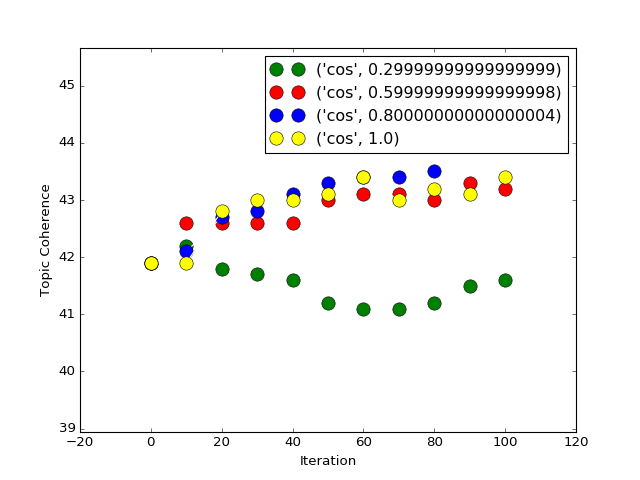

In [47]:
df_tc_welda_vmf_20news = load_topic_coherence("vmf_welda.embedding-20news-dim-50.txt")
df_tc_welda_vmf_20news.columns = ["embedding-dimension", "distance-method", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_vmf_20news = df_tc_welda_vmf_20news.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf_20news, ["distance-method", "lambda"])

<IPython.core.display.Javascript object>


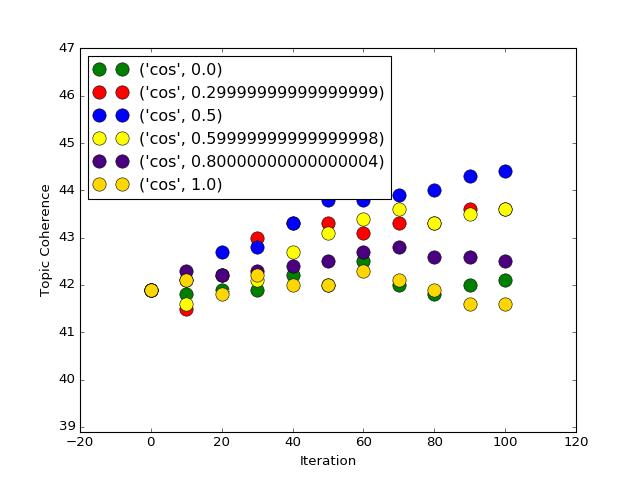

In [48]:
df_tc_welda_vmf = load_topic_coherence("vmf_welda.conc-20.txt")
df_tc_welda_vmf.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_vmf["concentration"]
df_tc_welda_vmf = df_tc_welda_vmf.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf, ["distance-method", "lambda"])

#### conc-50

<IPython.core.display.Javascript object>


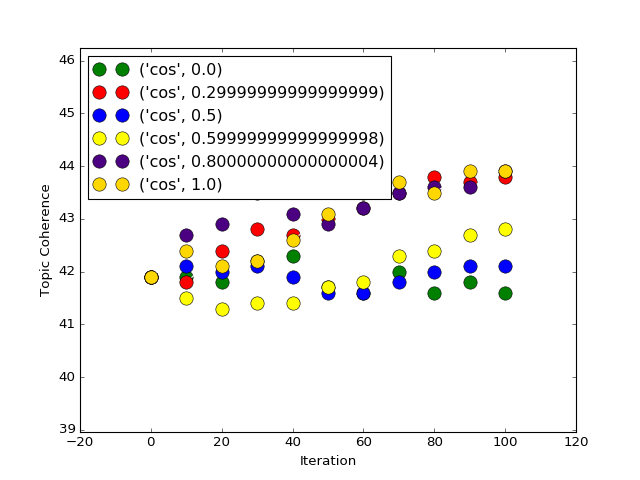

In [33]:
df_tc_welda_vmf_conc50 = load_topic_coherence("vmf_welda.conc-50.txt")
df_tc_welda_vmf_conc50.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
del df_tc_welda_vmf_conc50["concentration"]
df_tc_welda_vmf_conc50 = df_tc_welda_vmf_conc50.sort_values(["distance-method", "lambda", "iteration"])
plot_iteration_for(df_tc_welda_vmf_conc50, ["distance-method", "lambda"])

**Full kappafactor investigation**

In [294]:
df_tc_welda_vmf_kappa = load_topic_coherence("vmf_welda.conc-experiments.txt")
df_tc_welda_vmf_kappa.columns = ["embedding-dimension", "distance-method", "concentration", "lambda", "iteration", "TC", "TC_std"]
df_tc_welda_vmf_kappa = df_tc_welda_vmf_kappa.sort_values(["distance-method", "lambda", "iteration"])

**TODO: BETTER PLOTS**

<IPython.core.display.Javascript object>


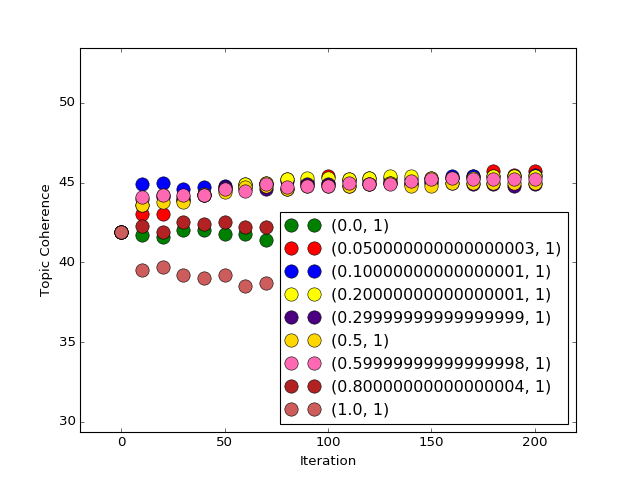

In [309]:
plot_iteration_for(
    df_tc_welda_vmf_kappa[(df_tc_welda_vmf_kappa["embedding-dimension"] == "200") &
                          (df_tc_welda_vmf_kappa["lambda"].apply(lambda x: x in [0.0, 0.1, 0.5, 1.0]))],
    ["concentration", "lambda"])

## Runtimes

**For 20news corpus:**

In [40]:
df_runtimes = pnd.DataFrame.from_records([
    ("LDA", "iterations=1500, threads=4", "8min"),
    ("LFLDA", "iterations=400, embedding-dimension=200, lambda=0.6, threads=5", "23h 30min"),
    ("Gaussian LDA", "iterations=100, embedding-dimension=50, threads=2", "19h 40min"),
    ("topicvec", "iterations=100, embedding-dimension=100, threads=4", "45min"),
    ("topicvec", "iterations=100, embedding-dimension=200, threads=4", "53min"),
    ("sHDP on NIPS!", "kappa=0.8, tau=0.6", "20 min"),
    ("WELDA", "iterations=100, lambda=0.5, threads=4", "4 h"),
], columns=["method", "notes", "runtime"])
df_runtimes

,method,notes,runtime
0,LDA,"iterations=1500, threads=4",8min
1,LFLDA,"iterations=400, embedding-dimension=200, lambda=0.6, threads=5",23h 30min
2,Gaussian LDA,"iterations=100, embedding-dimension=50, threads=2",19h 40min
3,topicvec,"iterations=100, embedding-dimension=100, threads=4",45min
4,topicvec,"iterations=100, embedding-dimension=200, threads=4",53min
5,sHDP on NIPS!,"kappa=0.8, tau=0.6",20 min
6,WELDA,"iterations=100, lambda=0.5, threads=4",4 h


## Document classification

### Setup

In [4]:
import multiprocessing
for p in multiprocessing.active_children():
    p.terminate()
    p.join()

multiprocessing.active_children()

[]

In [ ]:
def load_document_topics(folder):
    if os.path.isdir(folder):
        document_topics = [f for f in os.listdir(folder) if "document-topics" in f or "theta" in f]
        assert len(document_topics) == 1
        document_topics = folder + "/" + document_topics[0]
    else:
        document_topics = folder
    
    df_return = pnd.read_csv(document_topics, sep=" ", header=None)
    if len(df_return.columns) == 50:
        df_return.columns = range(1, 51)
    elif len(df_return.columns) == 51:
        df_return.columns = ["class"] + range(1, 51)
    elif len(df_return.columns) == 52:
        df_return.columns = ["class", "freq"] + range(1, 51)
    elif len(df_return.columns) == 201:
        df_return.columns = ["class"] + range(1, 201)
    elif len(df_return.columns) == 250:
        df_return.columns = range(1, 251)
    elif len(df_return.columns) == 251:
        df_return.columns = ["class"] + range(1, 251)
    else:
        raise Exception("unknown column count " + str(len(df_return.columns)))
    return df_return

def get_evaluation_metrics(y_test, y_predictions, average="macro"):
    precision = metrics.precision_score(y_test, y_predictions, average=average)
    recall = metrics.recall_score(y_test, y_predictions, average=average)
    f1 = metrics.f1_score(y_test, y_predictions, average=average)
    accuracy = metrics.accuracy_score(y_test, y_predictions)
    return precision, recall, f1, accuracy


def evaluate_document_classification(df_param, print_eval=False):
    nr_classes = len(set(df_param["class"].tolist()))
    nr_features = len(df_param.columns) - 1
    if print_eval:
        print "nr_classes = %d, nr_features = %d" % (nr_classes, nr_features)
    
    feature_columns = list(range(1, nr_features + 1))
    #X = df_param.as_matrix(feature_columns)
   
    train, test = train_test_split(df_param, test_size = 0.2, stratify=df_param["class"])
    feature_columns = df_param.columns[1:]
    assert len(feature_columns) == nr_features
    if print_eval:
        print "feature_columns = %s" % str(feature_columns)
        
    X_train = train.as_matrix(feature_columns)
    #X_train = normalize(X_train, norm="l1")
    X_test = test.as_matrix(feature_columns)
    if print_eval:
        print X_train.shape
        print X_test.shape
    
    model = svm.LinearSVC(penalty='l1', dual=False, random_state=21011991)
    y_train = train["class"].tolist()
    model.fit(X_train, y_train)
    
    y_test = test["class"].tolist()
    y_predictions = model.predict(X_test)
    if print_eval:
        print metrics.classification_report(y_test, y_predictions, digits=2)
    return get_evaluation_metrics(y_test, y_predictions)

def evaluate_experiment(f_param, classes_file, avg_we_file):
    df_return = load_document_topics(f_param)

    if classes_file:
        df_return.insert(0, "class",
                           pnd.read_csv("/data/wikipedia/2016-06-21/topic-models/" + classes_file,
                                  header=None))
    if avg_we_file:
        df_avg = pnd.read_csv(avg_we_file, header=None, sep=" ")
        assert len(df_avg) == len(df_return), "len(df_avg) = %d   !=   len(df_return) = %d" % (len(df_avg), len(df_return))
        nr_avg_dimensions = len(df_avg.columns) - 1
        avg_column_names = ["avg-" + str(i) for i in range(1, nr_avg_dimensions + 1)]
        df_avg.columns = ["class_avg"] + avg_column_names
        assert all(df_return["class"] == df_avg["class_avg"])
        
        df_return = pnd.concat([df_return, df_avg], axis=1)
        del df_return["class_avg"]
    return evaluate_document_classification(df_return, print_eval=False)

def run_experiment(exp_tuple, classes_file):
    e, avg_we = exp_tuple
    if "google" in e:
        embedding_data = "google"
    elif "20news.dim-50" in e:
        embedding_data = "20news.dim-50"
    elif "dim-50" in e:
        embedding_data = "dim-50"
    elif "dim-200" in e:
        embedding_data = "dim-200"
    else:
        embedding_data = None
        #raise Exception(e + ": embedding not known")
    
    params = parse_params(e)
    prec, rec, f1, acc = evaluate_experiment(e, classes_file, avg_we)

    exp_name = ""
    if os.path.isfile(e):
        exp_name = os.path.basename(os.path.dirname(e)) + "/" + os.path.basename(e)
    else:
        exp_name = os.path.basename(e)

    avg_we = os.path.basename(avg_we) if avg_we else None
    return (params, (exp_name, embedding_data, avg_we, prec, rec, f1, acc))

def evaluate_multiple_experiments(experiment_files, classes_file, avg_embeddings_file, threads=1):
    exp_tuples = []
    for e in experiment_files:
        if avg_embeddings_file:
            exp_tuples.append((e, avg_embeddings_file))
        exp_tuples.append((e, None))

    if threads == 1:
        results = map(partial(run_experiment, classes_file=classes_file), exp_tuples)
    else:
        try:
            p = Pool(threads)
            results = p.map(partial(run_experiment, classes_file=classes_file), exp_tuples)
        finally:
            p.close()
    
    params_lists = defaultdict(list)
    for params, result_tuple in results:
        for k, v in params.iteritems():
            params_lists[k].append(v)

    results = [r[1] for r in results]    
    
    df_return = pnd.DataFrame.from_records(results, columns=["experiment", "embedding", "avg-embedding", "precision", "recall", "f1", "accuracy"])
    for p in ["lambda"]:
        if p in params_lists.keys():
            df_return.insert(1, p, params_lists[p])
    df_return = df_return.sort_values(["embedding"])
    return df_return

In [3]:
df_foo = evaluate_experiment("/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.google.embedding.welda.gaussian.distance-cos.lambda-0-6",
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding")
df_foo
#'index = df_foo["avg-2"].index[df_foo["avg-2"].apply(np.isnan)]
#index
#df_foo.to_csv("/home/knub/df_foo", sep=" ", naRep="NAN")

(0.74007300009126153,
 0.7390608024919938,
 0.73570019584749491,
 0.74966770048737263)

In [303]:
pnd.get_option('display.max_columns')
pnd.set_option('display.max_columns', 300)
pnd.set_option('display.max_rows', 300)

### Avg. embedding

In [205]:
evaluate_multiple_experiments([
        "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding"
    ], None)

,experiment,embedding,precision,recall,f1,accuracy
0,topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding,dim-200,0.707263,0.706247,0.69709,0.720425


### LDA

In [24]:
dcs_lda_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.50-1500.alpha"))

df_dcs_lda = evaluate_multiple_experiments(dcs_lda_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=12)
df_dcs_lda

,experiment,embedding,avg-embedding,precision,recall,f1,accuracy
0,topic.20news.50-1500.alpha-0-002.beta-0-002,None,model.dim-200.skip-gram.embedding.avg-embedding,0.760792,0.756633,0.751765,0.768276
1,topic.20news.50-1500.alpha-0-002.beta-0-002,None,None,0.685616,0.694689,0.685189,0.704918
2,topic.20news.50-1500.alpha-0-002.beta-0-005,None,model.dim-200.skip-gram.embedding.avg-embedding,0.763470,0.761599,0.756461,0.772707
3,topic.20news.50-1500.alpha-0-002.beta-0-005,None,None,0.694181,0.705606,0.692792,0.715995
4,topic.20news.50-1500.alpha-0-002.beta-0-01,None,model.dim-200.skip-gram.embedding.avg-embedding,0.751920,0.752345,0.747577,0.763403
5,topic.20news.50-1500.alpha-0-002.beta-0-01,None,None,0.680156,0.694762,0.672978,0.707133
6,topic.20news.50-1500.alpha-0-002.beta-0-02,None,model.dim-200.skip-gram.embedding.avg-embedding,0.756400,0.753734,0.748741,0.766504
7,topic.20news.50-1500.alpha-0-002.beta-0-02,None,None,0.707729,0.698130,0.684397,0.712450
8,topic.20news.50-1500.alpha-0-002.beta-0-05,None,model.dim-200.skip-gram.embedding.avg-embedding,0.762713,0.757877,0.751628,0.769163
9,topic.20news.50-1500.alpha-0-002.beta-0-05,None,None,0.685683,0.709545,0.693565,0.722198


**Same values as reported in TopicVec paper**

In [34]:
dcs_lda250_experiments = sorted(find_files("/data/wikipedia/2016-06-21/topic-models", "20news.250-1500.alpha"))

df_dcs_lda250 = evaluate_multiple_experiments(dcs_lda250_experiments,
                     None,
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=12)
df_dcs_lda250

,experiment,embedding,avg-embedding,precision,recall,f1,accuracy
0,topic.20news.250-1500.alpha-0-02.beta-0-02,None,model.dim-200.skip-gram.embedding.avg-embedding,0.778932,0.773878,0.773263,0.782455
1,topic.20news.250-1500.alpha-0-02.beta-0-02,None,None,0.724909,0.718861,0.716805,0.727957


### WELDA-Gaussian

**50 topics**

In [10]:
dcs_welda_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda_experiments = find_files(dcs_welda_experiment_folder, ".welda.gaussian.")

df_dcs_welda = evaluate_multiple_experiments(dcs_welda_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=12)
#df_dcs_welda = df_dcs_welda[df_dcs_welda["lambda"] != 0.0]
df_dcs_welda.sort_values(["embedding", "lambda", "avg-embedding"])


,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
22,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0,0.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.771551,0.765859,0.761606,0.776252
23,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0,0.0,dim-200,None,0.676999,0.665949,0.655401,0.677448
18,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3,0.3,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.738969,0.725898,0.723215,0.736819
19,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3,0.3,dim-200,None,0.620517,0.567140,0.565645,0.576872
10,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.748662,0.744616,0.741744,0.751883
11,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5,0.5,dim-200,None,0.634877,0.578054,0.572599,0.585290
6,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.741760,0.735476,0.732458,0.743465
7,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6,0.6,dim-200,None,0.619307,0.549529,0.546325,0.556934
4,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8,0.8,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.734750,0.730885,0.726785,0.739920
5,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8,0.8,dim-200,None,0.566300,0.469165,0.485000,0.477182


**250 topics**

In [30]:
dcs_welda250_experiments = find_files(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02", "dim-200.skip-gram.embedding.welda.gaussian")
dcs_welda250_experiments = [f + "/welda.iteration-100.document-topics" for f in dcs_welda250_experiments]

df_dcs_welda250 = evaluate_multiple_experiments(dcs_welda250_experiments,
                     "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=15)
df_dcs_welda250.sort_values(["embedding", "lambda", "avg-embedding"])


,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
10,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.802722,0.798177,0.796964,0.806380
11,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,None,0.745376,0.740223,0.738118,0.747895
6,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.767874,0.765384,0.763696,0.773593
7,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,None,0.679969,0.656080,0.658384,0.662827
4,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.762601,0.758610,0.756676,0.766947
5,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,None,0.658533,0.629026,0.633723,0.634914
2,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-100.document-topics,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.763478,0.758745,0.756792,0.767833
3,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-100.document-topics,0.6,dim-200,None,0.638607,0.616661,0.620596,0.623394
0,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8/welda.iteration-100.document-topics,0.8,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.744850,0.738682,0.736163,0.747895
1,model.dim-200.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-8/welda.iteration-100.document-topics,0.8,dim-200,None,0.576705,0.539894,0.545683,0.546743


In [197]:
foo = sorted(find_files(
    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5", "document-topics"))
df_foo = evaluate_multiple_experiments(foo,
                     "topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.restricted.classes",
                     threads=15)
df_foo
#df_dcs_welda250.sort_values(["embedding", "lambda"])

#evaluate_experiment("/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-000.document-topics",
#                    )
#del df_doc_class["file"]
#evaluate_document_classification(df_doc_class)

,experiment,lambda,embedding,precision,recall,f1,accuracy
0,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-000.document-topics,0.5,20news.dim-50,0.741066,0.734500,0.733658,0.743022
30,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-030.document-topics,0.5,20news.dim-50,0.680189,0.660773,0.662474,0.668144
31,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-031.document-topics,0.5,20news.dim-50,0.681002,0.659374,0.661538,0.667700
32,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-032.document-topics,0.5,20news.dim-50,0.678476,0.657203,0.659557,0.665042
33,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-033.document-topics,0.5,20news.dim-50,0.681439,0.661955,0.663923,0.669916
34,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-034.document-topics,0.5,20news.dim-50,0.679668,0.659967,0.662032,0.668144
35,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-035.document-topics,0.5,20news.dim-50,0.672264,0.651437,0.654077,0.658839
36,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-036.document-topics,0.5,20news.dim-50,0.675134,0.655641,0.657176,0.663270
37,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-037.document-topics,0.5,20news.dim-50,0.679374,0.661591,0.663483,0.669030
38,model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-5/welda.iteration-038.document-topics,0.5,20news.dim-50,0.672662,0.655249,0.656988,0.662384


### WELDA-vMF

In [35]:
dcs_welda_vmf_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_welda_vmf_experiments = [f + "/welda.iteration-100.document-topics" for f in find_files(dcs_welda_vmf_experiment_folder,
                                                                                            "dim-200.skip-gram.embedding.welda.vmf.")]
dcs_welda_vmf_experiments = [f for f in dcs_welda_vmf_experiments if os.path.exists(f)]

df_dcs_welda_vmf = evaluate_multiple_experiments(dcs_welda_vmf_experiments,
                     "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                     "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                     threads=16)
#df_dcs_welda = df_dcs_welda[df_dcs_welda["lambda"] != 0.0]
df_dcs_welda_vmf.sort_values(["embedding", "lambda", "avg-embedding"])


,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
10,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.771791,0.764185,0.761774,0.774036
2,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.760814,0.756711,0.751132,0.768276
11,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,None,0.687442,0.671866,0.660868,0.683651
3,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,None,0.691381,0.674506,0.666056,0.685423
0,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.748006,0.737514,0.734314,0.747895
12,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.756047,0.746408,0.742726,0.756757
13,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,None,0.618755,0.593941,0.582180,0.603899
1,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,None,0.580308,0.542572,0.540360,0.551617
20,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-20.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.719363,0.716283,0.711352,0.728401
4,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.750218,0.743634,0.738991,0.754541


In [13]:
df_dcs_welda_vmf.sort_values(["embedding", "lambda", "avg-embedding"])

,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
12,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.768182,0.766316,0.761685,0.775809
13,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-0/welda.iteration-100.document-topics,0.0,dim-200,None,0.689268,0.675401,0.663097,0.686752
14,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.746354,0.738011,0.735304,0.747452
15,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-3/welda.iteration-100.document-topics,0.3,dim-200,None,0.596332,0.592261,0.582454,0.602570
4,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.761892,0.754372,0.749822,0.764289
2,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.739293,0.730774,0.727190,0.742136
5,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,None,0.622763,0.607796,0.592293,0.617634
3,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-5/welda.iteration-100.document-topics,0.5,dim-200,None,0.594397,0.513659,0.520757,0.521489
0,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.lambda-0-6/welda.iteration-100.document-topics,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.745094,0.740261,0.734852,0.751883
10,model.dim-200.skip-gram.embedding.welda.vmf.distance-cos.conc-50.lambda-0-6/welda.iteration-100.document-topics,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.744837,0.737415,0.734314,0.747452


### LFLDA

#### 50 Topics

In [37]:
dcs_lflda_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02"
dcs_lflda_experiments = [f + "/iteration-100.document-topics" for f in find_files(dcs_lflda_experiment_folder, "lflda.")]

df_dcs_lflda = evaluate_multiple_experiments(dcs_lflda_experiments,
                    "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                    threads=8)
df_dcs_lflda

,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
0,lflda.dim-200.lambda-0-6.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.746042,0.745517,0.739158,0.757643
1,lflda.dim-200.lambda-0-6.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics,0.6,dim-200,None,0.690466,0.677058,0.665207,0.689411
2,lflda.dim-200.lambda-1-0.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics,1.0,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.699391,0.699488,0.692765,0.712007
3,lflda.dim-200.lambda-1-0.alphasum-1-7469466076451743.beta-0-01607008995057715/iteration-100.document-topics,1.0,dim-200,None,0.024681,0.067796,0.024395,0.070447


#### 250 topics

In [57]:
dcs_lflda250_experiment_folder = "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02"
dcs_lflda250_experiments = [f + "/iteration-100.document-topics" for f in find_files(dcs_lflda250_experiment_folder, "lflda.")]

df_dcs_lflda250 = evaluate_multiple_experiments(dcs_lflda250_experiments,
                    "topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.restricted.classes",
                    "/data/wikipedia/2016-06-21/topic-models/topic.20news.250-1500.alpha-0-02.beta-0-02/model.dim-200.skip-gram.embedding.avg-embedding",
                    threads=4)
df_dcs_lflda250

,experiment,lambda,embedding,avg-embedding,precision,recall,f1,accuracy
0,lflda.dim-200.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics,0.6,dim-200,model.dim-200.skip-gram.embedding.avg-embedding,0.774150,0.769694,0.768733,0.778467
1,lflda.dim-200.lambda-0-6.alphasum-5-0.beta-0-02/iteration-100.document-topics,0.6,dim-200,None,0.714164,0.710470,0.708831,0.719096


### TopicVec

**Infers topics for each category**

In [14]:
df_dcs_topicvec = pnd.DataFrame.from_records([
    ("50-dimensions, no separate topics (50), raw topic proportions", 0.351, 0.330, 0.306, 0.341),
    ("50-dimensions, no separate topics (50), topic proportions + mean WE", 0.611, 0.611, 0.597, 0.624),
        
    ("200-dimensions, no separate topics (50), raw topic proportions", 0.347, 0.344, 0.314, 0.355),
    ("200-dimensions, no separate topics (50), topic proportions + mean WE", 0.742, 0.731, 0.721, 0.745),
        
    ("200-dimensions, no separate topics (250), raw topic proportions", 0.409, 0.373, 0.337, 0.385),
    ("200-dimensions, no separate topics (250), topic proportions + mean WE", 0.743, 0.734, 0.725, 0.748),

    ("200-dimensions, separate topics per category, raw topic proportions", 0.743, 0.739, 0.739, 0.746),
    ("200-dimensions, separate topics per category, topic proportions + mean WE", 0.786, 0.783, 0.783, 0.791),
], columns=["method", "precision", "recall", "f1", "accuracy"])
df_dcs_topicvec

,method,precision,recall,f1,accuracy
0,"50-dimensions, no separate topics (50), raw topic proportions",0.351,0.330,0.306,0.341
1,"50-dimensions, no separate topics (50), topic proportions + mean WE",0.611,0.611,0.597,0.624
2,"200-dimensions, no separate topics (50), raw topic proportions",0.347,0.344,0.314,0.355
3,"200-dimensions, no separate topics (50), topic proportions + mean WE",0.742,0.731,0.721,0.745
4,"200-dimensions, no separate topics (250), raw topic proportions",0.409,0.373,0.337,0.385
5,"200-dimensions, no separate topics (250), topic proportions + mean WE",0.743,0.734,0.725,0.748
6,"200-dimensions, separate topics per category, raw topic proportions",0.743,0.739,0.739,0.746
7,"200-dimensions, separate topics per category, topic proportions + mean WE",0.786,0.783,0.783,0.791


In [105]:
df_dc_topicvec = evaluate_multiple_experiments(
        ["/home/stefan.bunk/topicvec/results/corpus-orig.dim-200.iterations-500"], None)
df_dc_topicvec

,experiment,embedding,precision,recall,f1,accuracy
0,corpus-orig.dim-200.iterations-500,dim-200.skip-gram,0.333071,0.32422,0.303254,0.330527


### Gaussian LDA

In [14]:
df_dc_gaussian = evaluate_multiple_experiments(["/home/stefan.bunk/Gaussian_LDA/results/dim-50.alpha-0-02/100.document-topic"],
                    "topic.20news.50-1500.alpha-0-02.beta-0-02/model.dim-50.skip-gram.embedding.restricted.classes",
                    None)
df_dc_gaussian

,experiment,embedding,avg-embedding,precision,recall,f1,accuracy
0,dim-50.alpha-0-02/100.document-topic,20news.dim-50,None,0.416335,0.434248,0.405006,0.447497


### sHDP

**Waiting for parameter settings**

## TODO

* Google embeddings
* How to ensure same preprocessing for all methods? Is this desired?

## Topics

In [10]:
def read_restricted_vectors(vector_file):
    vectors = dict()
    with open(vector_file, "r") as f:
        for line in f:
            split = line.rstrip().split()
            word = split[0]
            vector = [float(v) for v in split[1:]]
            vectors[word] = vector
    return vectors

def read_topics(topics_file):
    with open(topics_file, "r") as f:
        first_line = f.readline()
        if "topic-count" in first_line:
            header = "infer"
        else:
            header = None
        
    df_return = pnd.read_csv(topics_file, sep=" ", header=header)
    nr_cols = len(df_return.columns)
    df_return = df_return[df_return.columns[-10:]]
    return df_return

In [11]:
VECTOR_FILE_20NEWS_50 = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/20news.dim-50.skip-gram.embedding.restricted.vocab.embedding.txt"
VECTOR_FILE_200 = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/dim-200.skip-gram.embedding.restricted.vocab.embedding.txt"
vectors_200 = read_restricted_vectors(VECTOR_FILE_200)
vectors_20news_50 = read_restricted_vectors(VECTOR_FILE_20NEWS_50)

**Analyzing the base topics from the original LDA**

In [12]:
TOPICS = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.ssv"
df_topics_lda = read_topics(TOPICS)
df_topics_lda.head(1)

,0,1,2,3,4,5,6,7,8,9
0,would,one,writes,like,think,article,know,get,time,people


In [13]:
def get_vector(w, vectors):
    if w in vectors:
        return vectors[w]
    elif w.capitalize() in vectors:
        return vectors[w.capitalize()]
    elif w.upper() in vectors:
        return vectors[w.upper()]
    else:
        raise Exception("Word '%s' not found" % w)

def get_words_from_topics(df_param):
    l = list()
    for topic_id, row in enumerate(df_param.values):
        for word in row:
            l.append((topic_id, word))
    return l

def plot_topics_in_embedding_space(reduction_method, df_param, vectors, show_words=True, highlight_topics=None):
    words = get_words_from_topics(df_param)
    words = [(t, w) for t, w in words if w in vectors or w.capitalize() in vectors or w.upper() in vectors]
    #print words
    embeddings = [get_vector(w, vectors) for _, w in words]
    embeddings = np.array(embeddings)
    #print embeddings.shape

    X = reduction_method(embeddings)
    df_tmp = pnd.DataFrame()
    df_tmp["x"] = X[:,0]
    df_tmp["y"] = X[:,1]
    df_tmp["word"] = [w for _, w in words]
    df_tmp["topic_id"] = [topic for topic, _ in words]
    if highlight_topics:
        num_rows = len(highlight_topics)
        colors = np.linspace(0, 1, num_rows)
        colordict = dict(zip(highlight_topics, colors))
        df_tmp["color"] = df_tmp["topic_id"].apply(lambda x: colordict[x] if x in highlight_topics else 'white')
    else:
        num_rows = len(df_param.index)
        colors = np.linspace(0, 1, num_rows)
        colordict = dict(zip(range(num_rows), colors))
        df_tmp["color"] = df_tmp["topic_id"].apply(lambda x: colordict[x])

    plt.figure(figsize=(12, 8))
    
    def scatter(df_scatter):
        plt.scatter(df_scatter.x, df_scatter.y, c=df_scatter.color, s=80)
    
    if highlight_topics:
        df_tmp_non_highlighted = df_tmp[df_tmp.topic_id.apply(lambda x: x not in highlight_topics)]
        df_tmp_highlighted = df_tmp[df_tmp.topic_id.apply(lambda x: x in highlight_topics)]
        scatter(df_tmp_non_highlighted)
        scatter(df_tmp_highlighted)
    else:
        scatter(df_tmp)
    
    if show_words:
        ylim = plt.gca().get_ylim()
        step = (ylim[1] - ylim[0]) / 100

        for _, row in df_tmp.iterrows():
            if highlight_topics:
                if row.topic_id in highlight_topics:
                    plt.text(row.x, row.y - step, row.word, horizontalalignment='center', verticalalignment='top')
            else:
                plt.text(row.x, row.y - step, row.word, horizontalalignment='center', verticalalignment='top')

In [14]:
df_topics_lda.head(3)

,0,1,2,3,4,5,6,7,8,9
0,would,one,writes,like,think,article,know,get,time,people
1,thanks,please,anyone,know,would,writes,article,university,e-mail,apr
2,god,jesus,bible,christ,church,christian,one,christians,faith,law


<IPython.core.display.Javascript object>


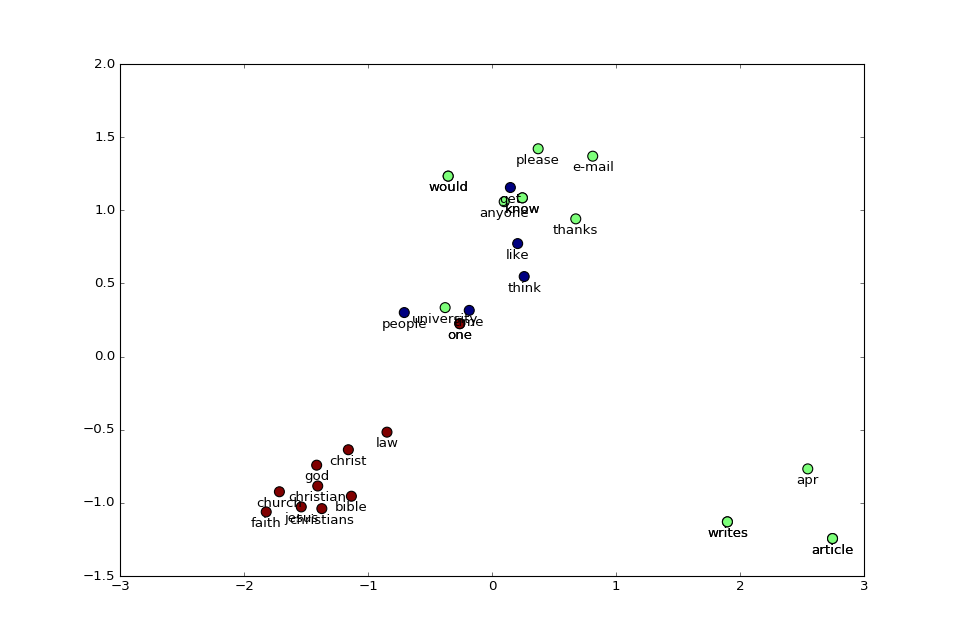

In [15]:
plot_topics_in_embedding_space(pca, df_topics_lda.head(3), vectors_20news_50)

<IPython.core.display.Javascript object>


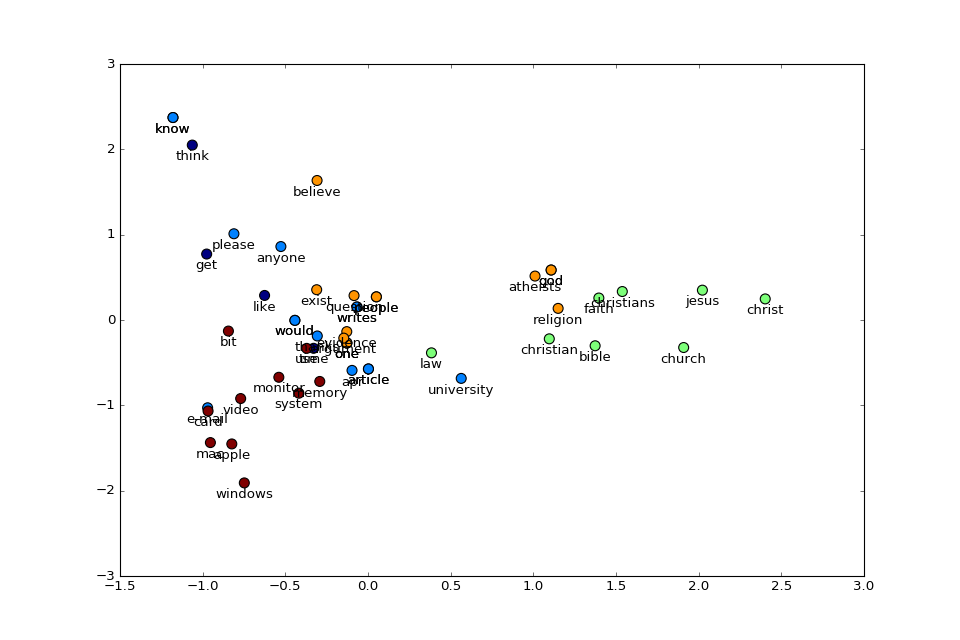

In [288]:
plot_topics_in_embedding_space(pca, df_topics_lda.head(5), vectors_200)

In [276]:
interesting_topics = [0, 4, 16]
df_topics_lda.ix[interesting_topics]

,0,1,2,3,4,5,6,7,8,9
0,would,one,writes,like,think,article,know,get,time,people
4,card,windows,bit,mac,system,use,video,apple,memory,monitor
16,israel,israeli,jews,arab,arabs,writes,article,peace,would,lebanese


**Topic 0** is a general stopword topic, it is spread widely

**Topic 4** is a good, coherent topic, where a good distribution can be approximated

**Topic 16** has the *stopword problem*: a general good topic is polluted by stopwords, which add noise to the parameter estimation of the distribution and can lead to a wrong mean

<IPython.core.display.Javascript object>


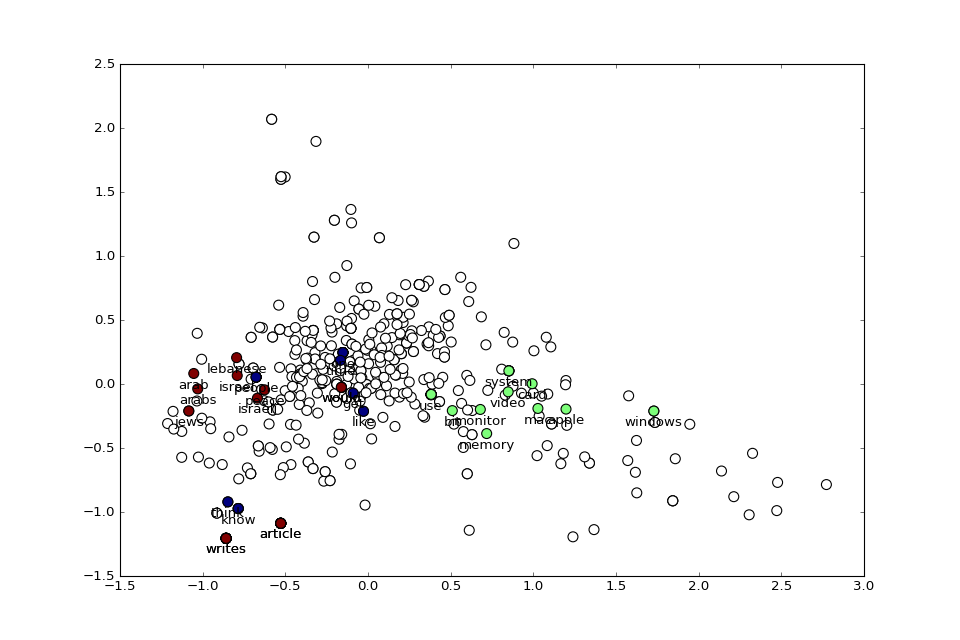

In [277]:
plot_topics_in_embedding_space(pca, df_topics_lda, vectors_200, show_words=True, highlight_topics=interesting_topics)

<IPython.core.display.Javascript object>


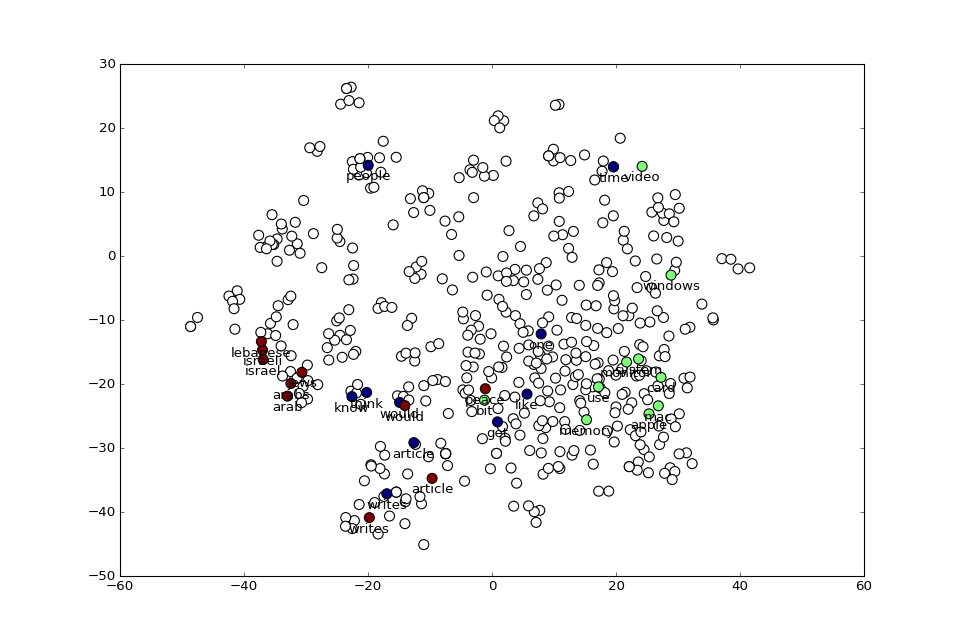

In [265]:
plot_topics_in_embedding_space(tsne_with_init_pca, df_topics_lda, vectors_200, show_words=True, highlight_topics=interesting_topics)

Learn stopwords with alpha0Boost LDA. That way, all the stopwords group together in topic 0.
Then, always replace words from topic 0 during sampling.

Other idea: Do not consider stopwords, when estimating distribution parameters.

## Misc

### LDA Convergence

<IPython.core.display.Javascript object>


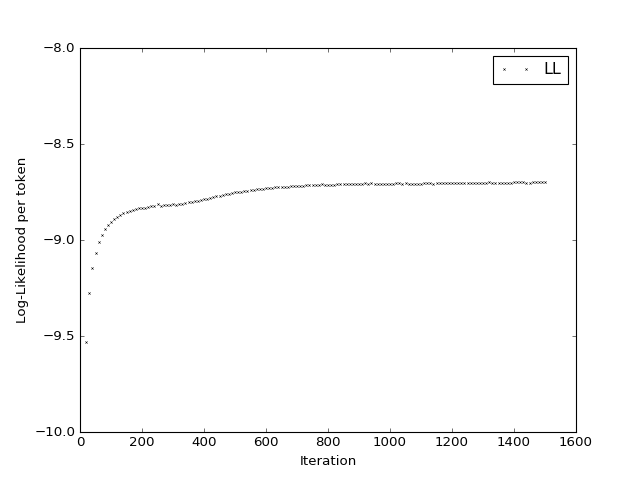

In [16]:
df_lda_convergence = pnd.read_csv("/home/stefan.bunk/master-thesis/results/lda_convergence.tsv", sep="\t", header=None)
df_lda_convergence.columns = ["iteration", "LL"]

plt.figure()
plt.plot(df_lda_convergence.iteration, df_lda_convergence.LL, linestyle="None", color='black', marker='x', markersize=2)

plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood per token")
plt.ylim((-10, -8))

plt.legend(loc="best")


### LSH vs KDTree

<IPython.core.display.Javascript object>


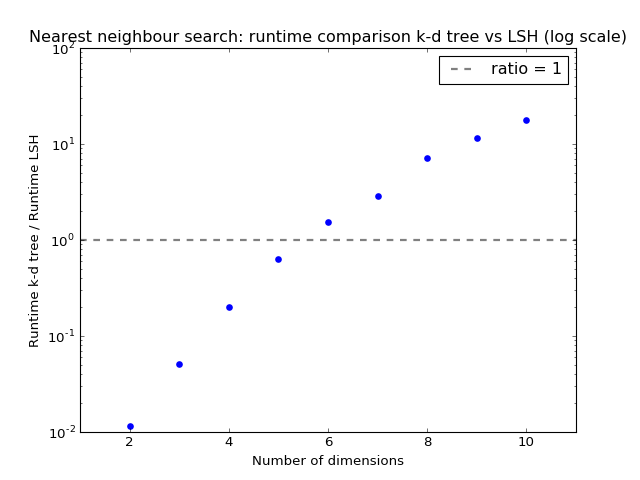

In [45]:
df_lsh_vs_kdtree = pnd.read_csv("/home/stefan.bunk/master-thesis/results/nearest_neighbour_search_performance.tsv",
                                sep="\t")
df_lsh_vs_kdtree["ratio"] = df_lsh_vs_kdtree["kdtree"] / df_lsh_vs_kdtree["lsh"]

plt.figure()
plt.axhline(y=1, linewidth=2, color='gray', ls='--', label="ratio = 1")
#plt.axvline(x=5, linewidth=2, color='gray', ls='--')
plt.semilogy(df_lsh_vs_kdtree["dimensions"], df_lsh_vs_kdtree["ratio"], 'o', markeredgecolor='none', label=None)
plt.xlabel("Number of dimensions")
plt.ylabel("Runtime k-d tree / Runtime LSH")
plt.legend()
plt.xlim((1, 11))
plt.title("Nearest neighbour search: runtime comparison k-d tree vs LSH (log scale)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[:1], labels[:1])

In [281]:
TOPICS_WELDA = "/data/wikipedia/2016-06-21/topic-models/topic.20news.50-1500.alpha-0-02.beta-0-02/model.20news.dim-50.skip-gram.embedding.welda.gaussian.distance-cos.lambda-0-6/welda.iteration-200.topics"
translated_interesting_topics = [33, 37]
df_topics_welda = read_topics(TOPICS_WELDA)
df_topics_welda.ix[translated_interesting_topics]

,1,2,3,4,5,6,7,8,9,10
33,water,power,air,nuclear,light,high,cooling,temperature,cycle,heat
37,card,windows,bit,video,mcmains,memory,mhz,system,mac,problem


<IPython.core.display.Javascript object>


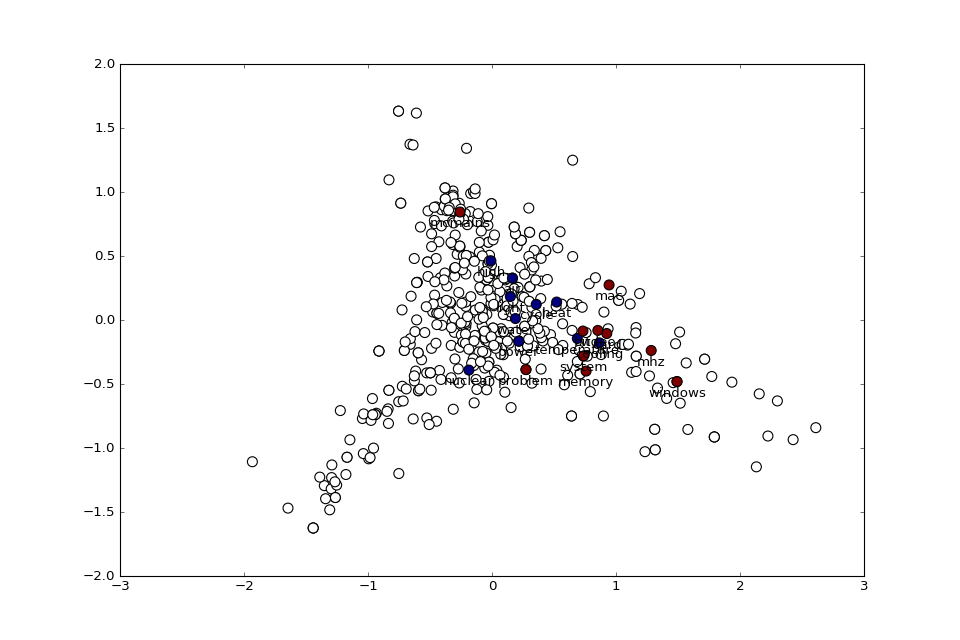

In [283]:
plot_topics_in_embedding_space(pca, df_topics_welda, vectors_200, show_words=True, highlight_topics=translated_interesting_topics)